In [1]:
import sqlite3
import pandas as pd
import numpy as np
import tensorflow
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
conn = sqlite3.connect('MatchDB.db')
df = pd.read_sql_query("SELECT * FROM Games", 
                       conn)

In [3]:
df = df.drop(['HomeTeam', 'AwayTeam', 'League', 'Country', 'date', 'id', 'match_id', 'HomexG', 'AwayxG'], axis=1)
df = df.drop(['AwayPoss', 'AwayShots', 'AwaySonT', 'AwaySoffT', 'AwayBS', 'AwayCor', 'AwayOff', 'AwayFoul', 'AwayYellow', 'AwayPass', 'AwayAccPass', 'AwayPassOff', 'AwayAccLongB', 'AwayAccLongBpercent', 'AwayAccCross', 'AwayAccCrosspercent', 'AwaySuccDribb', 'AwaySuccDribbpercent', 'AwayDuelsW', 'AwayTackW', 'AwayTackWpercent', 'AwayInt', 'AwayClear'], axis= 1)
df = df.dropna()

In [4]:
def compare_values(row):
    if row['HGoals'] > row['AGoals']:
        return 0
    elif row['AGoals'] > row['HGoals']:
        return 1
    else:
        return 2
    
df['Winner'] = df.apply(compare_values, axis= 1)

In [5]:
from tensorflow.keras.utils import to_categorical 
prediction = df.drop(['HGoals', 'AGoals'], axis=1).astype(float)
target_1 = df['Winner'].astype(float)

target_1 = to_categorical(target_1)

X_train, X_test, y_train, y_test = train_test_split(prediction, target_1, test_size=0.2, random_state=42)

In [6]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

In [7]:
n_cols = len(X_train.columns)
input_shape = (n_cols,)

In [8]:

# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)

In [9]:
lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tensorflow.keras.optimizers.Adam(learning_rate=lr_schedule)

model = Sequential()

model.add(Dense(250, activation = 'relu', input_shape = input_shape))
model.add(BatchNormalization())
model.add(Dense(200, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(100, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(50, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(3, activation = 'sigmoid'))

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
hist = model.fit(X_train, y_train,
                 validation_split = 0.2,
                 epochs = 500,
                 callbacks = [early_stopping]
                )

Epoch 1/500
624/624 [==============================] - 4s 3ms/step - loss: 0.5473 - accuracy: 0.7490 - val_loss: 0.0839 - val_accuracy: 0.9723
Epoch 2/500
624/624 [==============================] - 2s 3ms/step - loss: 0.0774 - accuracy: 0.9738 - val_loss: 0.0079 - val_accuracy: 0.9988
Epoch 3/500
624/624 [==============================] - 2s 3ms/step - loss: 0.0523 - accuracy: 0.9807 - val_loss: 0.0163 - val_accuracy: 0.9962
Epoch 4/500
624/624 [==============================] - 2s 3ms/step - loss: 0.0502 - accuracy: 0.9833 - val_loss: 0.0591 - val_accuracy: 0.9864
Epoch 5/500
624/624 [==============================] - 2s 3ms/step - loss: 0.0210 - accuracy: 0.9934 - val_loss: 0.1263 - val_accuracy: 0.9655
Epoch 6/500
624/624 [==============================] - 2s 3ms/step - loss: 0.0220 - accuracy: 0.9921 - val_loss: 0.0062 - val_accuracy: 0.9988
Epoch 7/500
624/624 [==============================] - 2s 3ms/step - loss: 0.0203 - accuracy: 0.9938 - val_loss: 0.0121 - val_accuracy: 0.9980

In [10]:
result = model.evaluate(X_test, y_test)

195/195 [==============================] - 0s 1ms/step - loss: 0.1165 - accuracy: 0.9459


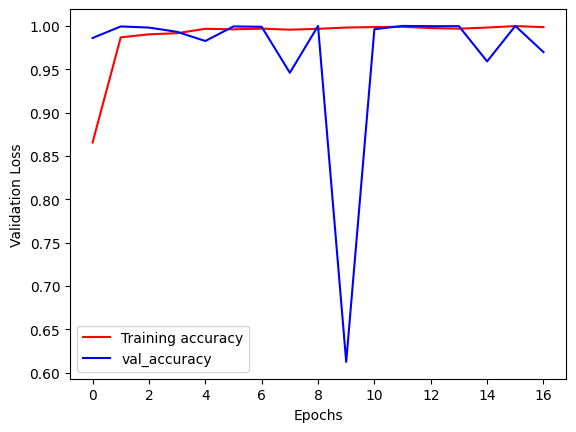

In [11]:
plt.plot(np.sqrt(hist.history['accuracy']), 'r', label='Training accuracy')
plt.plot(np.sqrt(hist.history['val_accuracy']), 'b', label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()

In [12]:
print(hist.history['accuracy'])
best_score = max(hist.history['accuracy'])
# best_score2 = min(hist.history['val_loss'])
print(best_score)




[0.7489973902702332, 0.9738319516181946, 0.9806998372077942, 0.9833065867424011, 0.9933828115463257, 0.9921295642852783, 0.9937838315963745, 0.9913274645805359, 0.9933326840400696, 0.9962401986122131, 0.9974433779716492, 0.9980449080467224, 0.9950370788574219, 0.9936334490776062, 0.9962401986122131, 0.9996491074562073, 0.9971926808357239]
0.9996491074562073


In [13]:
print(y_test.shape)

(6234, 3)


In [14]:
model.save('model_file.h5')

c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
import keras_tuner
from tensorflow import keras

In [16]:
def build_model(hp):
    model2 = Sequential()
    model2.add(Dense(
        hp.Choice('units', [100, 150, 200, 250]),
        activation = 'relu'))
    model2.add(BatchNormalization())
    model2.add(Dense(
        hp.Choice('units', [100, 150, 200, 250]),
        activation = 'relu'))
    model2.add(BatchNormalization())
    model2.add(Dense(
        hp.Choice('units', [100, 150, 200, 250]),
        activation = 'relu'))
    model2.add(BatchNormalization())
    model2.add(Dense(3, activation = 'sigmoid'))
    model2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model2

In [17]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials = 100)

INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json


In [18]:
tuner.search(X_train, y_train, validation_split = 0.2)
best_model = tuner.get_best_models(num_models=1)[0]

INFO:tensorflow:Oracle triggered exit


In [19]:
predictions = best_model.predict(X_test)
import numpy as np
predicted_classes = np.argmax(predictions, axis=1)
y_test_classes = np.argmax(y_test, axis=1)


InvalidArgumentError: Graph execution error:

Detected at node 'sequential/dense/Relu' defined at (most recent call last):
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 1041, in launch_instance
      app.start()
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 530, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\simon\AppData\Local\Temp\ipykernel_30796\3570935118.py", line 1, in <module>
      predictions = best_model.predict(X_test)
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
      return self(x, training=False)
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\sequential.py", line 405, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\activations.py", line 321, in relu
      return backend.relu(
    File "c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend.py", line 5397, in relu
      x = tf.nn.relu(x)
Node: 'sequential/dense/Relu'
Matrix size-incompatible: In[0]: [32,26], In[1]: [50,250]
	 [[{{node sequential/dense/Relu}}]] [Op:__inference_predict_function_58337]

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test_classes, predicted_classes)
print(f"Accuracy on test data: {accuracy:.2f}")


Accuracy on test data: 0.74


In [ ]:
import os

# Define the file path
file_path = "./untitled_project/tuner0.json"  # Adjust the path if necessary

# Check if the file exists before attempting to delete it
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"File '{file_path}' deleted successfully.")
else:
    print(f"The file '{file_path}' does not exist.")


File './untitled_project/tuner0.json' deleted successfully.
